# Import the dataset from the archive

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')
import sys, os

Mounted at /content/drive


In [2]:
#if not os.path.isfile('/content/drive/MyDrive/archive.zip'):
!unzip "/content/drive/MyDrive/mpv_data.zip" -d "/content/"

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: /content/movie_posters_dataset_vectorscope/Drama/888693.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/88915.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/889222.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/88939.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/889588.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/889595.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/889652.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/88992.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/89006.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/89010.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/89015.jpg  
  inflating: /content/movie_posters_dataset_vectorscope/Drama/89018.jpg  
  inflating: /content/movie_posters_datase

# Loading the dataset


### Loading data

**Import libraries**

In [3]:
import os
import logging


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

**Set Arguments**

In [4]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 28  

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 25e-3            # The initial Learning Rate: 1e-3, the best result so far: 25e-3, Validation Accuracy: 0.46680497925311204, Test Accuracy: 0.46837193225025925
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 10       # How many epochs before decreasing learning rate (if using a step-down policy), initial value: 20
GAMMA = 0.9          # Multiplicative factor for learning rate step-down, initial value: 0.1

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [5]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      # Crops a central square patch of the image
                                      transforms.CenterCrop(224),
                                      # 224 because torchvision's AlexNet needs a 224x224 input!
                                      # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(),  # Turn PIL Image to torch.Tensor
                                      # Normalizes tensor with mean and standard deviation
                                      transforms.Normalize(
                                          (0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])


**Dataset Class**

In [6]:
from torchvision.datasets import VisionDataset

from PIL import Image

import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


class MoviePosters(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(MoviePosters, self).__init__(root, transform=transform, target_transform=target_transform)

        self.split = split # This defines the split you are going to use
                           # (split files are called 'train.txt' and 'test.txt')

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indexes to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        # Open file in read only mode and read all lines
        file = open(self.split, "r")
        lines = file.readlines()

        # Filter out the lines which start with 'BACKGROUND_Google' as asked in the homework
        self.elements = [i for i in lines if not i.startswith('BACKGROUND_Google')]

        # Delete BACKGROUND_Google class from dataset labels
        self.classes = sorted(os.listdir(os.path.join(self.root, "")))
        # self.classes.remove("BACKGROUND_Google")


    def __getitem__(self, index):
        ''' 
        __getitem__ should access an element through its index
        Args:
            index (int): Index
        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''

        img = pil_loader(os.path.join(self.root, self.elements[index].rstrip()))

        target = self.classes.index(self.elements[index].rstrip().split('/')[0])

        image, label = img, target # Provide a way to access image and label via index
                           # Image should be a PIL Image
                           # label can be int

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        # Provides a way to get the length (number of elements) of the dataset
        length =  len(self.elements)
        return length

**Prepare Dataset**

In [7]:
from sklearn.model_selection import train_test_split

DATA_DIR = 'movie_posters_dataset_vectorscope'

SPLIT_TRAIN = 'train.txt'

train_dataset_ = MoviePosters(
    DATA_DIR, split=SPLIT_TRAIN, transform=train_transform)

train_len_list = list(range(len(train_dataset_)))

train_indexes, val_indexes = train_test_split(train_len_list, shuffle=True, test_size=0.5)

train_dataset = Subset(train_dataset_, train_indexes)
val_dataset = Subset(train_dataset_, val_indexes)

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))


Train Dataset: 19274
Valid Dataset: 19274


**Prepare Dataloaders**

In [8]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
val_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


**Prepare Network**

In [9]:
net = alexnet(pretrained=False)  # Loading AlexNet model, set pretrained

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
# nn.Linear in pytorch is a fully connected layer
net.classifier[6] = nn.Linear(4096, 28)
# The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 28 outputs
# It is strongly suggested to study torchvision.models.alexnet source code


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


**Prepare Training**

In [10]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train**

In [11]:
# By default, everything is loaded to cpu
net = net.to(DEVICE)  # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark  # Calling this optimizes runtime

train_loss_list = []
train_acc_list = []

val_loss_list = []
val_acc_list = []

train_loss_list_all = []
val_loss_list_all = []

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
    print("\n##################################################")
    print('Starting epoch {}/{}, LR = {}'.format(epoch +
          1, NUM_EPOCHS, scheduler.get_lr()))

    # Iterate over the dataset
    train_running_corrects = 0

    for images, labels in train_dataloader:
        # Bring data over the device of choice
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        net.train()  # Sets module in training mode

        # PyTorch, by default, accumulates gradients after each backward pass
        # We need to manually set the gradients to zero before starting a new iteration
        optimizer.zero_grad()  # Zero-ing the gradients

        # Forward pass to the network
        train_outputs = net(images)

        # Compute loss based on output and ground truth
        train_loss = criterion(train_outputs, labels)
        train_loss_list.append(train_loss.item())

        # Log loss
        if current_step % LOG_FREQUENCY == 0:
            print('Step {}, Loss {}'.format(current_step, train_loss.item()))

        # Compute gradients for each layer and update weights
        train_loss.backward()  # backward pass: computes gradients
        optimizer.step()  # update weights based on accumulated gradients

        current_step += 1

        # Get predictions
        _, train_preds = torch.max(train_outputs.data, 1)

        # Update Corrects
        train_running_corrects += torch.sum(train_preds ==
                                            labels.data).data.item()

    # Append train loss list
    train_loss_list_all.append(train_loss.item())

    # Calculate Accuracy
    accuracy_train = train_running_corrects / float(len(train_dataset))

    train_acc_list.append(accuracy_train)

    # Step the scheduler
    scheduler.step()

    ##############################################################################################################################
    ### VALIDATION AFTER EACH EPOCH ###

    # this will bring the network to GPU if DEVICE is cuda
    net = net.to(DEVICE)
    net.train(False)  # Set Network to evaluation mode

    val_running_corrects = 0
    for images, labels in tqdm(val_dataloader):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        # Forward Pass
        val_outputs = net(images)

        # Compute loss based on output and ground truth
        val_loss = criterion(val_outputs, labels)
        val_loss_list.append(val_loss.item())

        # Get predictions
        _, val_preds = torch.max(val_outputs.data, 1)

        # Update Corrects
        val_running_corrects += torch.sum(val_preds == labels.data).data.item()

    # Append val loss list
    val_loss_list_all.append(val_loss.item())

    # Calculate Accuracy
    accuracy_val = val_running_corrects / float(len(val_dataset))

    print('Validation Accuracy: {}'.format(accuracy_val))

    val_acc_list.append(accuracy_val)



##################################################
Starting epoch 1/30, LR = [0.025]


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Step 0, Loss 3.328587770462036
Step 10, Loss 3.0743041038513184
Step 20, Loss 2.2089359760284424
Step 30, Loss 2.3081119060516357
Step 40, Loss 2.1309406757354736
Step 50, Loss 2.1902785301208496
Step 60, Loss 2.3120968341827393
Step 70, Loss 2.154749631881714


100%|██████████| 76/76 [00:42<00:00,  1.77it/s]

Validation Accuracy: 0.2499221749507108

##################################################
Starting epoch 2/30, LR = [0.025]


Step 80, Loss 2.1897847652435303
Step 90, Loss 2.224490165710449
Step 100, Loss 2.2410683631896973
Step 110, Loss 2.1823337078094482
Step 120, Loss 2.21848726272583
Step 130, Loss 2.203552007675171
Step 140, Loss 2.253662347793579


100%|██████████| 76/76 [00:43<00:00,  1.73it/s]

Validation Accuracy: 0.2941268029469752

##################################################
Starting epoch 3/30, LR = [0.025]


Step 150, Loss 2.1254684925079346
Step 160, Loss 2.270688533782959
Step 170, Loss 2.179692029953003
Step 180, Loss 2.1855738162994385
Step 190, Loss 2.1627769470214844
Step 200, Loss 2.221900701522827
Step 210, Loss 2.0446407794952393
Step 220, Loss 2.256281614303589


100%|██████████| 76/76 [00:44<00:00,  1.72it/s]

Validation Accuracy: 0.3186676351561689

##################################################
Starting epoch 4/30, LR = [0.025]


Step 230, Loss 2.130995035171509
Step 240, Loss 2.116905689239502
Step 250, Loss 2.121992349624634
Step 260, Loss 2.0535690784454346
Step 270, Loss 2.20686674118042
Step 280, Loss 2.103854179382324
Step 290, Loss 2.280719518661499


100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.32406350524022

##################################################
Starting epoch 5/30, LR = [0.025]


Step 300, Loss 2.1473779678344727
Step 310, Loss 2.0941991806030273
Step 320, Loss 2.1913158893585205
Step 330, Loss 2.125523567199707
Step 340, Loss 2.150789260864258
Step 350, Loss 2.088524341583252
Step 360, Loss 2.1513924598693848
Step 370, Loss 2.179039716720581


100%|██████████| 76/76 [00:44<00:00,  1.69it/s]

Validation Accuracy: 0.316332883677493

##################################################
Starting epoch 6/30, LR = [0.025]


Step 380, Loss 2.1398508548736572
Step 390, Loss 2.074934482574463
Step 400, Loss 2.1436614990234375
Step 410, Loss 2.0947327613830566
Step 420, Loss 2.1862878799438477
Step 430, Loss 1.9455955028533936
Step 440, Loss 2.0975990295410156


100%|██████████| 76/76 [00:46<00:00,  1.62it/s]

Validation Accuracy: 0.3059562104389333

##################################################
Starting epoch 7/30, LR = [0.025]


Step 450, Loss 2.1053850650787354
Step 460, Loss 2.196922540664673
Step 470, Loss 2.1477742195129395
Step 480, Loss 2.081176519393921
Step 490, Loss 2.0924324989318848
Step 500, Loss 2.006817579269409
Step 510, Loss 2.1377968788146973
Step 520, Loss 2.075812339782715


100%|██████████| 76/76 [00:45<00:00,  1.69it/s]

Validation Accuracy: 0.2983812389747847

##################################################
Starting epoch 8/30, LR = [0.025]


Step 530, Loss 2.1056413650512695
Step 540, Loss 2.0112388134002686
Step 550, Loss 1.9985219240188599
Step 560, Loss 2.1950316429138184
Step 570, Loss 2.1757256984710693
Step 580, Loss 2.1045725345611572
Step 590, Loss 2.133174419403076


100%|██████████| 76/76 [00:44<00:00,  1.69it/s]

Validation Accuracy: 0.31903081871951855

##################################################
Starting epoch 9/30, LR = [0.025]


Step 600, Loss 2.1568353176116943
Step 610, Loss 2.1644058227539062
Step 620, Loss 2.1207876205444336
Step 630, Loss 2.009169816970825
Step 640, Loss 2.0444579124450684
Step 650, Loss 2.0705556869506836
Step 660, Loss 2.1057326793670654
Step 670, Loss 2.096755266189575


100%|██████████| 76/76 [00:44<00:00,  1.72it/s]

Validation Accuracy: 0.32608695652173914

##################################################
Starting epoch 10/30, LR = [0.025]


Step 680, Loss 2.1265623569488525
Step 690, Loss 2.1630046367645264
Step 700, Loss 1.944323182106018
Step 710, Loss 2.1994411945343018
Step 720, Loss 2.1541974544525146
Step 730, Loss 2.1077775955200195
Step 740, Loss 2.1234359741210938


100%|██████████| 76/76 [00:44<00:00,  1.71it/s]

Validation Accuracy: 0.3137387153678531

##################################################
Starting epoch 11/30, LR = [0.020250000000000004]


Step 750, Loss 2.10955810546875
Step 760, Loss 2.0946645736694336
Step 770, Loss 2.0376574993133545
Step 780, Loss 2.104902744293213
Step 790, Loss 2.1304643154144287
Step 800, Loss 2.0944504737854004
Step 810, Loss 2.227971315383911
Step 820, Loss 2.104440689086914


100%|██████████| 76/76 [00:44<00:00,  1.69it/s]

Validation Accuracy: 0.32883677492995744

##################################################
Starting epoch 12/30, LR = [0.022500000000000003]


Step 830, Loss 2.036874532699585
Step 840, Loss 2.117379665374756
Step 850, Loss 2.1120615005493164
Step 860, Loss 2.081509590148926
Step 870, Loss 2.0344767570495605
Step 880, Loss 2.095956802368164
Step 890, Loss 2.026914119720459


100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.32883677492995744

##################################################
Starting epoch 13/30, LR = [0.022500000000000003]


Step 900, Loss 2.2068352699279785
Step 910, Loss 2.009028196334839
Step 920, Loss 2.051605224609375
Step 930, Loss 2.186033010482788
Step 940, Loss 2.0840506553649902
Step 950, Loss 2.1928210258483887
Step 960, Loss 2.2176833152770996
Step 970, Loss 2.098024845123291


100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.33252049392964617

##################################################
Starting epoch 14/30, LR = [0.022500000000000003]


Step 980, Loss 1.9750921726226807
Step 990, Loss 2.011683940887451
Step 1000, Loss 2.1054506301879883
Step 1010, Loss 2.0820915699005127
Step 1020, Loss 2.114454746246338
Step 1030, Loss 2.1662347316741943
Step 1040, Loss 2.1095714569091797


100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.3278509909722943

##################################################
Starting epoch 15/30, LR = [0.022500000000000003]


Step 1050, Loss 2.0772979259490967
Step 1060, Loss 2.041633367538452
Step 1070, Loss 2.0079174041748047
Step 1080, Loss 2.132688045501709
Step 1090, Loss 2.0346200466156006
Step 1100, Loss 2.093419313430786
Step 1110, Loss 2.0635106563568115
Step 1120, Loss 2.0246524810791016


100%|██████████| 76/76 [00:45<00:00,  1.68it/s]

Validation Accuracy: 0.3309639929438622

##################################################
Starting epoch 16/30, LR = [0.022500000000000003]


Step 1130, Loss 1.9828121662139893
Step 1140, Loss 2.012038230895996
Step 1150, Loss 1.9389982223510742
Step 1160, Loss 2.0466487407684326
Step 1170, Loss 1.9971204996109009
Step 1180, Loss 1.975547432899475
Step 1190, Loss 2.0835304260253906


100%|██████████| 76/76 [00:45<00:00,  1.68it/s]

Validation Accuracy: 0.3273321573103663

##################################################
Starting epoch 17/30, LR = [0.022500000000000003]


Step 1200, Loss 2.081300735473633
Step 1210, Loss 2.0721046924591064
Step 1220, Loss 2.1371216773986816
Step 1230, Loss 2.0768866539001465
Step 1240, Loss 2.0665791034698486
Step 1250, Loss 2.0548133850097656
Step 1260, Loss 1.9486587047576904
Step 1270, Loss 2.05979585647583


100%|██████████| 76/76 [00:45<00:00,  1.68it/s]

Validation Accuracy: 0.3343364117463941

##################################################
Starting epoch 18/30, LR = [0.022500000000000003]


Step 1280, Loss 2.095728635787964
Step 1290, Loss 2.011350393295288
Step 1300, Loss 1.9483590126037598
Step 1310, Loss 1.8462737798690796
Step 1320, Loss 2.1001381874084473
Step 1330, Loss 2.063039779663086
Step 1340, Loss 2.024129629135132


100%|██████████| 76/76 [00:45<00:00,  1.67it/s]


Validation Accuracy: 0.3268133236484383

##################################################
Starting epoch 19/30, LR = [0.022500000000000003]
Step 1350, Loss 2.0976791381835938
Step 1360, Loss 2.0081191062927246
Step 1370, Loss 2.0781517028808594
Step 1380, Loss 2.032679796218872
Step 1390, Loss 1.9455885887145996
Step 1400, Loss 2.0627121925354004
Step 1410, Loss 1.9327032566070557
Step 1420, Loss 2.2107880115509033


100%|██████████| 76/76 [00:45<00:00,  1.68it/s]

Validation Accuracy: 0.3201722527757601

##################################################
Starting epoch 20/30, LR = [0.022500000000000003]


Step 1430, Loss 2.0232255458831787
Step 1440, Loss 2.0950613021850586
Step 1450, Loss 2.0095057487487793
Step 1460, Loss 2.060636043548584
Step 1470, Loss 2.1376166343688965
Step 1480, Loss 2.0544722080230713
Step 1490, Loss 2.086787223815918


100%|██████████| 76/76 [00:46<00:00,  1.62it/s]

Validation Accuracy: 0.32945937532427105

##################################################
Starting epoch 21/30, LR = [0.018225000000000005]


Step 1500, Loss 2.017085075378418
Step 1510, Loss 2.0127933025360107
Step 1520, Loss 2.0587596893310547
Step 1530, Loss 2.0725417137145996
Step 1540, Loss 2.0340325832366943
Step 1550, Loss 2.1476473808288574
Step 1560, Loss 2.0839016437530518
Step 1570, Loss 2.0815367698669434


100%|██████████| 76/76 [00:45<00:00,  1.69it/s]

Validation Accuracy: 0.3295112586904638

##################################################
Starting epoch 22/30, LR = [0.020250000000000004]


Step 1580, Loss 1.8401951789855957
Step 1590, Loss 2.025081157684326
Step 1600, Loss 2.0479843616485596
Step 1610, Loss 2.1491143703460693
Step 1620, Loss 1.888837456703186
Step 1630, Loss 1.9987050294876099
Step 1640, Loss 2.013197660446167


100%|██████████| 76/76 [00:45<00:00,  1.69it/s]

Validation Accuracy: 0.31114454705821315

##################################################
Starting epoch 23/30, LR = [0.020250000000000004]


Step 1650, Loss 2.0458853244781494
Step 1660, Loss 1.8365976810455322
Step 1670, Loss 2.1432600021362305
Step 1680, Loss 1.9345808029174805
Step 1690, Loss 2.020855188369751
Step 1700, Loss 2.0039596557617188
Step 1710, Loss 2.0349392890930176
Step 1720, Loss 2.0222604274749756


100%|██████████| 76/76 [00:45<00:00,  1.67it/s]

Validation Accuracy: 0.32198817059250806

##################################################
Starting epoch 24/30, LR = [0.020250000000000004]


Step 1730, Loss 2.0105228424072266
Step 1740, Loss 2.0126078128814697
Step 1750, Loss 2.0501580238342285
Step 1760, Loss 1.9510565996170044
Step 1770, Loss 2.054589033126831
Step 1780, Loss 2.024113893508911
Step 1790, Loss 1.8557751178741455


100%|██████████| 76/76 [00:45<00:00,  1.67it/s]

Validation Accuracy: 0.3194458856490609

##################################################
Starting epoch 25/30, LR = [0.020250000000000004]


Step 1800, Loss 1.9039528369903564
Step 1810, Loss 1.9952247142791748
Step 1820, Loss 1.886082649230957
Step 1830, Loss 2.025686502456665
Step 1840, Loss 1.7746570110321045
Step 1850, Loss 1.8461458683013916
Step 1860, Loss 2.0478744506835938
Step 1870, Loss 1.9464036226272583


100%|██████████| 76/76 [00:45<00:00,  1.68it/s]

Validation Accuracy: 0.3167998339732282

##################################################
Starting epoch 26/30, LR = [0.020250000000000004]


Step 1880, Loss 1.899854063987732
Step 1890, Loss 1.9207878112792969
Step 1900, Loss 1.9370001554489136
Step 1910, Loss 1.9967458248138428
Step 1920, Loss 2.002965211868286
Step 1930, Loss 2.0477445125579834
Step 1940, Loss 1.897451400756836


100%|██████████| 76/76 [00:45<00:00,  1.69it/s]

Validation Accuracy: 0.32805852443706546

##################################################
Starting epoch 27/30, LR = [0.020250000000000004]


Step 1950, Loss 1.9075813293457031
Step 1960, Loss 1.8347861766815186
Step 1970, Loss 1.8280285596847534
Step 1980, Loss 2.0215578079223633
Step 1990, Loss 1.7210235595703125
Step 2000, Loss 1.837896704673767
Step 2010, Loss 2.0971908569335938
Step 2020, Loss 1.9907108545303345


100%|██████████| 76/76 [00:44<00:00,  1.69it/s]

Validation Accuracy: 0.31036629656532116

##################################################
Starting epoch 28/30, LR = [0.020250000000000004]


Step 2030, Loss 1.823190450668335
Step 2040, Loss 2.0004422664642334
Step 2050, Loss 1.9257683753967285
Step 2060, Loss 2.0044338703155518
Step 2070, Loss 1.708030343055725
Step 2080, Loss 1.9098891019821167
Step 2090, Loss 1.8927327394485474


100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.32157310366296565

##################################################
Starting epoch 29/30, LR = [0.020250000000000004]


Step 2100, Loss 1.7518147230148315
Step 2110, Loss 1.7576309442520142
Step 2120, Loss 1.6781830787658691
Step 2130, Loss 1.7783955335617065
Step 2140, Loss 1.655194878578186
Step 2150, Loss 1.8323874473571777
Step 2160, Loss 1.9407985210418701
Step 2170, Loss 1.9827840328216553


100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.3129604648749611

##################################################
Starting epoch 30/30, LR = [0.020250000000000004]


Step 2180, Loss 1.6976773738861084
Step 2190, Loss 1.8592991828918457
Step 2200, Loss 1.769398808479309
Step 2210, Loss 1.7721545696258545
Step 2220, Loss 1.878884196281433
Step 2230, Loss 1.762058973312378
Step 2240, Loss 1.791312336921692


100%|██████████| 76/76 [00:46<00:00,  1.63it/s]

Validation Accuracy: 0.2932966690878904


**Validation**

In [12]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy_val = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy_val))

100%|██████████| 76/76 [00:44<00:00,  1.70it/s]

Validation Accuracy: 0.2932966690878904


**Plots**

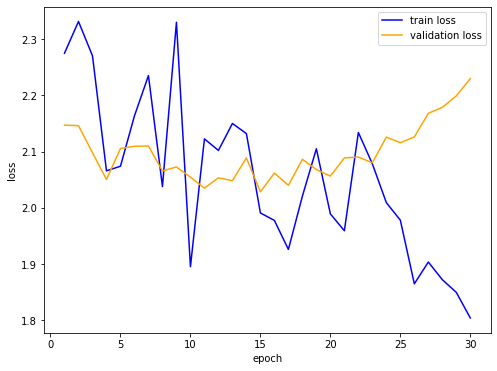

In [13]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [8, 6]

plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, len(train_loss_list_all)+1), train_loss_list_all, color='blue', label='train loss')
plt.plot(range(1, len(val_loss_list_all)+1), val_loss_list_all, color='orange', label='validation loss')
plt.legend(loc='upper right')
plt.show()

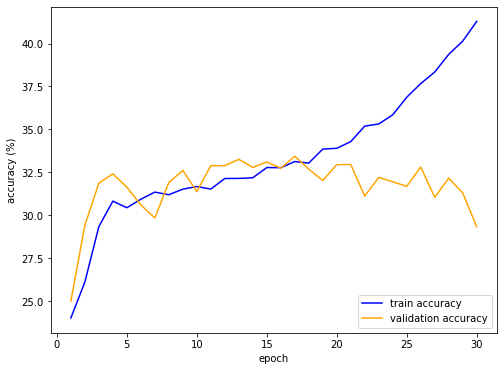

In [14]:
plt.xlabel('epoch')
plt.ylabel('accuracy (%)')
plt.plot(range(1, len(train_acc_list)+1), [x * 100 for x in train_acc_list], color='blue', label='train accuracy')
plt.plot(range(1, len(val_acc_list)+1), [x * 100 for x in val_acc_list], color='orange', label='validation accuracy')
plt.legend(loc='lower right')
plt.show()